<a href="https://colab.research.google.com/github/zkysfls/CSCI-6170/blob/main/CSCI6170_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part A**

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# metadata
print(bank_marketing.metadata)

# variable information
print(bank_marketing.variables)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

# **Dataset Datasheet: Bank Marketing (UCI)**

We choose the [UCI Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank%2Bmarketing) dataset for this lab.

**Motivation**: From the description in the website, we know that this dataset is made by a Portuguese banking institution. The data are collected by direct marketing campaigns (phone calls) and we are supposed to build a model to predict the success of a call, helping prioritize which clients to contact for an offer.

**Target definition**: The classification goal is to predict if the client will subscribe a term deposit (variable y). A positive y means subscribed and a negative y means no subsribed.

**Data Source & License**: Link: [UCI Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank%2Bmarketing) License: CC BY 4.0

**Feature dictionary**:
| Feature | Type | Description |
| :------ | :--- | :---------- |
| age | Integer | Client's age. |
| job | Categorical | Type of occupation |
| marital | Categorical | Marital status ('married', 'divorced', 'single'). |
| education | Categorical | Education level ('primary', 'secondary', 'tertiary', 'unknown'). |
| balance | Integer | Average yearly balance (in euros). |
| housing | Binary | Has a housing loan? ('yes', 'no'). |
| loan | Binary | Has a personal loan? ('yes', 'no'). |
| contact | Categorical | Contact communication type ('cellular', 'telephone', 'unknown'). |
| duration | Integer | LEAKAGE RISK: Last contact duration in seconds, highly affects the output target |
| poutcome | Categorical | Outcome of the previous marketing campaign. |

**Limitations/risks**: This dataset has label leakage risk, specifcally the duration feature. It will highly affects the prediction, like if duration=0 then y='no'. Also it has duplicate risk since the dataset description says more than one contact to the same client was required, so it is highly likely that this dataset contain duplicate clients' record.

**Data-quality audit**

In [ ]:
import pandas as pd

df = pd.concat([bank_marketing.data.features, bank_marketing.data.targets], axis=1)

missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
print("Missingness Summary (Top 5 Columns by %):")
print("\n")
if missing_pct.sum() == 0:
    print("No explicit NaN values found.")
else:
    print(missing_pct.head(5))
print("\n")
duplicate_count = df.duplicated().sum()
print(f"Duplicate Rows: {duplicate_count}")
print("\n")
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Action: Removed {duplicate_count} exact duplicates. New shape: {df.shape}")

print("\n")
target_counts = df['y'].value_counts()
target_pct = df['y'].value_counts(normalize=True) * 100
print("Target Distribution (Class Counts):")
print("\n")
summary_df = pd.DataFrame({'Count': target_counts, 'Percentage (%)': target_pct})
print(summary_df)

Missingness Summary (Top 5 Columns by %):


poutcome     81.747805
contact      28.798301
education     4.107407
job           0.637013
age           0.000000
dtype: float64


Duplicate Rows: 0




Target Distribution (Class Counts):


     Count  Percentage (%)
y                         
no   39922        88.30152
yes   5289        11.69848


We perform data quality audit on missingness, duplicate and target distribution and above are our results. Firstly, the dataset shows significant implicit missingness, primarily in the poutcome (81.7%) and contact (28.8%) features. High missingness in poutcome suggests that for the vast majority of the data, we have no historical interaction context to rely on for prediction. Second, the check returned 0 exact duplicates, indicating that every row in the dataset is unique. For target distribution, the dataset exhibits a significant class imbalance, with the negative class ("no") making up 88.3% of the data and the positive class ("yes") only 11.7%. This means a baseline model that simply guesses "no" for every client would achieve over 88% accuracy.

A significant ethical concern in this dataset is the potential for socio-economic discrimination based on features like job, education, and housing. The model may classify some individuals as low-value learned from these features and therefore exculde them from better financial opportunities

**Leakage-risk note**

Risk: duration column

Why it is leakage: This feature records the length of the phone call during which the client either accepts or rejects the offer. The duration is not known before a call is performed. Also, after the end of the call y is obviously known. If the model know this in advance it will allow model to cheat, for example, a duration of 0 clearly indicate that y is no.

Mitigation: Drop the column.

**Leakage-safe split**

In [ ]:
X_cleaned = X.drop(columns=['duration'])
split_point = int(len(X_cleaned) * 0.80)
train_df = X_cleaned.iloc[:split_point].copy()
test_df = X_cleaned.iloc[split_point:].copy()
train_y = y.iloc[:split_point].copy()
test_y = y.iloc[split_point:].copy()

# 3. VERIFICATION
print("--- Split Statistics ---")
print(f"Total Rows: {len(X_cleaned)}")
print(f"Training Rows (First 80%): {len(train_df)}")
print(f"Test Rows (Last 20%): {len(test_df)}")

print("\n--- Class Distribution (y) ---")
print(f"Train Positive Class: {train_y.value_counts(normalize=True)['yes']:.2%}")
print(f"Test Positive Class: {test_y.value_counts(normalize=True)['yes']:.2%}")


--- Split Statistics ---
Total Rows: 45211
Training Rows (First 80%): 36168
Test Rows (Last 20%): 9043

--- Class Distribution (y) ---
Train Positive Class: 6.73%
Test Positive Class: 31.58%


For this dataset, we implement a time-based split. Since the dataset description said the data has already been ordered in time. We just choose the top 80% as training set and the rest as testing set. Also we drop the 'duration' column to prevent leakage.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_features = ['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])


preprocessor.set_params(sparse_threshold=0)

baseline_pipeline.fit(train_df, train_y.values.ravel())


y_pred = baseline_pipeline.predict(test_df)
y_proba = baseline_pipeline.predict_proba(test_df)[:, 1]

print("--- Baseline Model: Gaussian Naive Bayes ---")
print(classification_report(test_y, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(test_y, y_proba):.4f}")

--- Baseline Model: Gaussian Naive Bayes ---
              precision    recall  f1-score   support

          no       0.78      0.78      0.78      6187
         yes       0.52      0.52      0.52      2856

    accuracy                           0.70      9043
   macro avg       0.65      0.65      0.65      9043
weighted avg       0.70      0.70      0.70      9043

ROC-AUC Score: 0.6933


We choose Gaussian Naive Bayes as our baseline model. It achieved an overall accuracy of 70% and an ROC-AUC score of 0.6933. While this accuracy is numerically lower than the 88.3% majority-class trivial baseline (guessing "no" for everyone), this model successfully identifies 52% (Recall) of the actual subscribers.

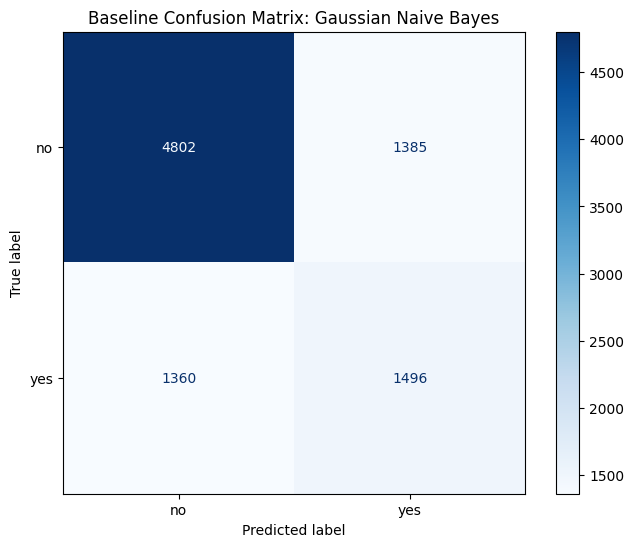

True Negatives: 4802
False Positives: 1385
False Negatives: 1360
True Positives: 1496


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y, y_pred, labels=baseline_pipeline.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_pipeline.classes_)
disp.plot(cmap='Blues', values_format='d', ax=ax)

plt.title('Baseline Confusion Matrix: Gaussian Naive Bayes')
plt.grid(False)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")